<a href="https://colab.research.google.com/github/CleliaCaetano/Predicting-Cryptocurrency-Prices/blob/main/Predicting_Cryptocurrency_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DEGREE: MSc Data Analytics

- Module: Predictive Analytics and Machine Learning using Python
- Assignment Title: Leveraging Random Forest, Regression, and KNN for Predicting
Cryptocurrency Prices

This assignment aligns with the unit's objectives of introducing learners to predictive analytics, machine learning,
and artificial intelligence (AI) concepts. You will apply these techniques using Python to solve a real-world problem: predicting Bitcoin prices.


Objectives:
- Understand the concepts of feature selection and its application in machine learning for price prediction.
- Transform orderbook data into time-series features and utilize these features for model training.
- Implement and compare different machine learning models for Bitcoin price prediction.


In [1]:
# Import Libraries:
# Data Processing
import pandas as pd
import numpy as np

# We can suppress the warnings messages that may appear when we run our code.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import data
df = pd.read_csv('Bitcoin.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Currency
0,2019-06-18,9128.269531,9149.763672,8988.606445,9062.045898,952850.0,USD
1,2019-06-19,9068.174805,9277.677734,9051.094727,9271.459961,131077.0,USD
2,2019-06-20,9271.567383,9573.689453,9209.416992,9519.200195,83052.0,USD
3,2019-06-21,9526.833984,10130.935547,9526.833984,10127.998047,76227.0,USD
4,2019-06-22,10151.890625,11171.013672,10083.189453,10719.981445,84485.0,USD


Phase 1: Data Exploration and Preparation

In [3]:
# check the category of each column.
# check which columns contains categorical variables (object) and numerical variables (int64, float64).
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1151 non-null   object 
 1   Open      1151 non-null   float64
 2   High      1151 non-null   float64
 3   Low       1151 non-null   float64
 4   Close     1151 non-null   float64
 5   Volume    1151 non-null   float64
 6   Currency  1151 non-null   object 
dtypes: float64(5), object(2)
memory usage: 63.1+ KB


Note: The dataset contains Categorical and Numerical Data:
- 'object' data types, representing categorical or qualitative information.
- 'float64' data types, representing quantitative information.

In [4]:
# calculate the number of unique values in each column.
df.nunique(axis = 0)

,0
Date,1151
Open,1151
High,1150
Low,1151
Close,1151
Volume,1144
Currency,1


In [5]:
# drop column that is irrelevant because only presents 1 variable.
df.drop(['Currency'], axis=1, inplace=True)

Missing Values

In [6]:
# display the missing values
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0


In [7]:
# convert the 'Date' column to the datetime64[ns] format to performing specific types of analysis.
df['Date'] = df['Date'].astype('datetime64[ns]')

In [8]:
# Get the first and last date in the 'Date' column
first_date = df['Date'].min()
last_date = df['Date'].max()

# Print the first and last date
print(f"First date in the dataset: {first_date}")
print(f"Last date in the dataset: {last_date}")

First date in the dataset: 2019-06-18 00:00:00
Last date in the dataset: 2022-08-23 00:00:00


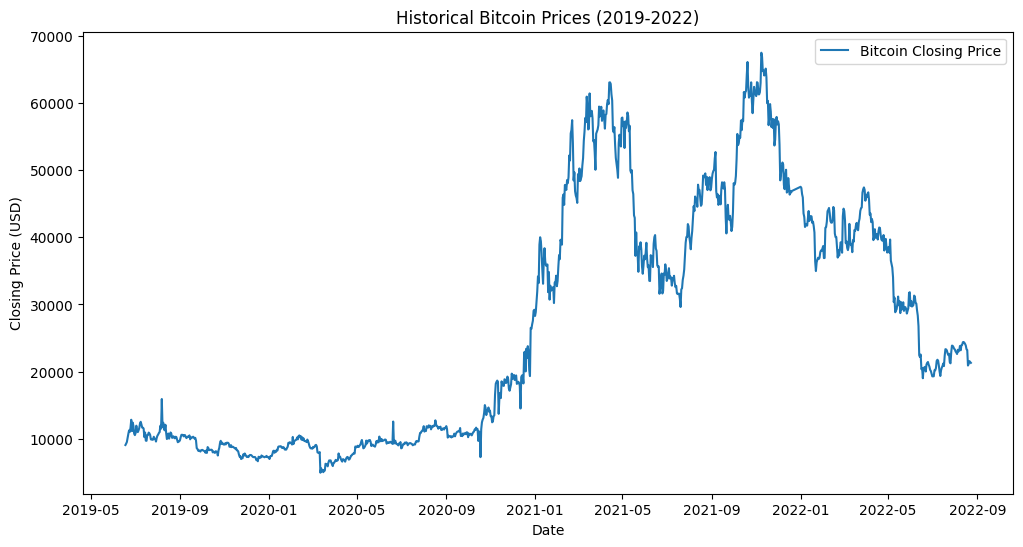

In [9]:
import matplotlib.pyplot as plt

# Plot the closing price over time
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='Bitcoin Closing Price')
plt.title('Historical Bitcoin Prices (2019-2022)')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.show()

In [10]:
# set the 'Date' column as the index label (making that column the primary reference point).
df.set_index('Date', inplace=True)

Seasonality

Missing Dates: DatetimeIndex(['2021-12-21', '2021-12-22', '2021-12-23', '2021-12-24',
               '2021-12-25', '2021-12-26', '2021-12-27', '2021-12-28',
               '2021-12-29', '2021-12-30', '2021-12-31', '2022-08-22'],
              dtype='datetime64[ns]', freq=None)


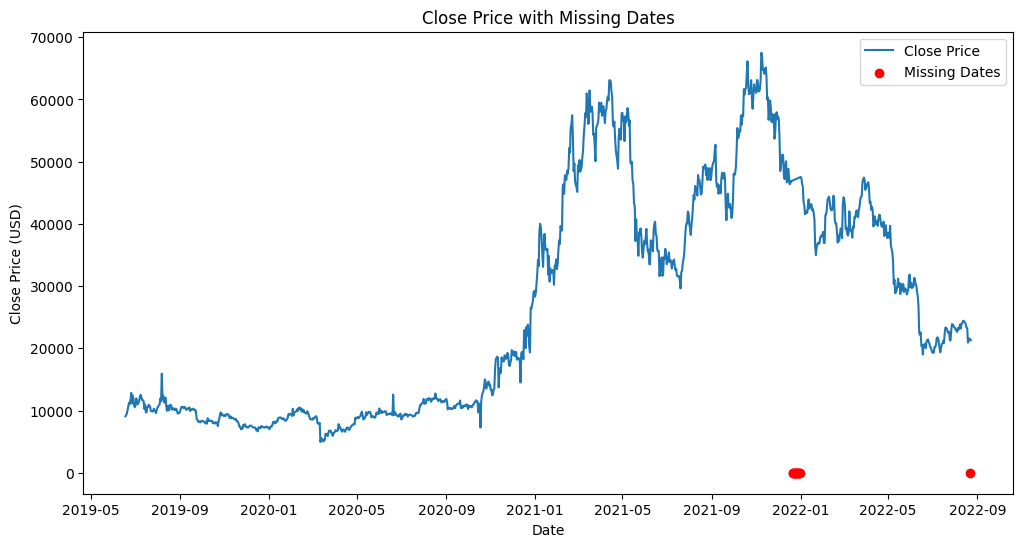

In [11]:
# Generate the full range of dates from the start to the end of the dataset
full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# Identify missing dates by comparing the full range with the actual data's index
missing_dates = full_date_range.difference(df.index)

# Plot the missing dates (if any)
if len(missing_dates) > 0:
    print(f"Missing Dates: {missing_dates}")
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Close'], label='Close Price')
    plt.scatter(missing_dates, [0] * len(missing_dates), color='red', label='Missing Dates')
    plt.title('Close Price with Missing Dates')
    plt.xlabel('Date')
    plt.ylabel('Close Price (USD)')
    plt.legend()
    plt.show()
else:
    print("No missing dates found in the 'Date' index.")

Imputing the missing values:

For this, in this particular study, Linear interpolation was chosen to deal with missing values in Date, in which it calculates the linear relationship of the data range and thus estimates the missing values, fitting these gaps.

In [12]:
# Define the missing dates
missing_dates = pd.to_datetime(['2021-12-21', '2021-12-22', '2021-12-23', '2021-12-24',
               '2021-12-25', '2021-12-26', '2021-12-27', '2021-12-28',
               '2021-12-29', '2021-12-30', '2021-12-31', '2022-08-22'])

# Reindex to add missing dates (this will introduce NaNs for missing dates)
df = df.reindex(df.index.union(missing_dates))

# Impute using the range 3 months before and after each missing date
def impute_with_range(df, missing_dates, months_before=3, months_after=3):
    for missing_date in missing_dates:
        # Define the range 3 months before and after the missing date
        start_date = missing_date - pd.DateOffset(months=months_before)
        end_date = missing_date + pd.DateOffset(months=months_after)

        # Extract data for the date range (3 months before and after)
        date_range = pd.date_range(start=start_date, end=end_date, freq='D')

        # Filter DataFrame for the date range that intersects with the index
        range_data = df.loc[date_range.intersection(df.index)]

        # Ensure there is data to interpolate
        if not range_data.empty:
            # Interpolate the missing value using the surrounding data (linear interpolation)
            df.loc[missing_date] = range_data.interpolate(method='linear').loc[missing_date]

    return df

# Apply the imputation for missing dates
df = impute_with_range(df, missing_dates)

# Check shape before and after interpolation
print(f"Shape of DataFrame before interpolation: {df.shape}")
print(f"Shape of DataFrame after interpolation: {df.shape}")

# Print the interpolated DataFrame
print("\nInterpolated DataFrame (missing dates only):")
print(df)

Shape of DataFrame before interpolation: (1163, 5)
Shape of DataFrame after interpolation: (1163, 5)

Interpolated DataFrame (missing dates only):
                    Open          High           Low         Close      Volume
2019-06-18   9128.269531   9149.763672   8988.606445   9062.045898    952850.0
2019-06-19   9068.174805   9277.677734   9051.094727   9271.459961    131077.0
2019-06-20   9271.567383   9573.689453   9209.416992   9519.200195     83052.0
2019-06-21   9526.833984  10130.935547   9526.833984  10127.998047     76227.0
2019-06-22  10151.890625  11171.013672  10083.189453  10719.981445     84485.0
...                  ...           ...           ...           ...         ...
2022-08-19  23219.097656  23219.097656  20898.304688  20902.404297  13856579.0
2022-08-20  20899.923828  21344.845703  20864.435547  21153.019531   7139073.0
2022-08-21  21153.412109  21695.794922  21125.320312  21561.177734   6657571.0
2022-08-22  21245.365234  21554.343750  21202.889648  21432.582

<Figure size 1200x800 with 0 Axes>

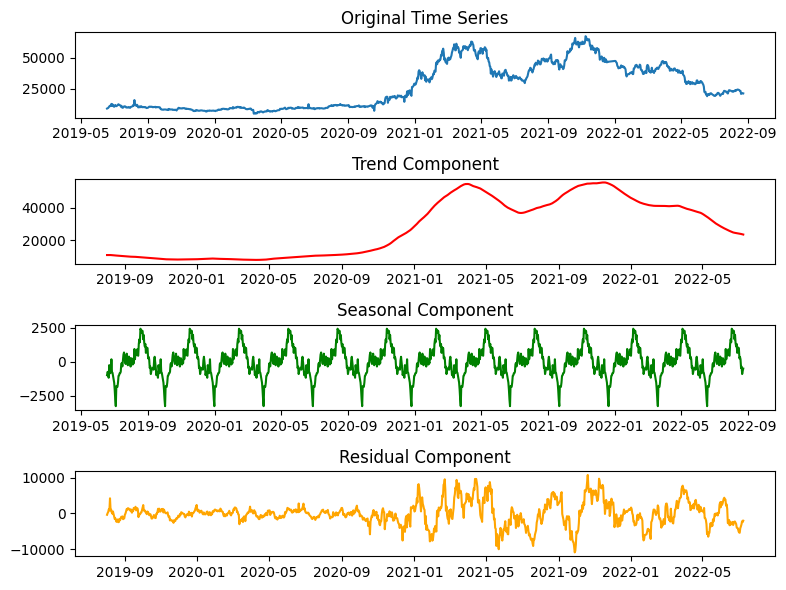

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition on the 'Close' column using additive model
decomposition = seasonal_decompose(df['Close'], model='additive', period=90)  # Period set to 90 for quarterly seasonality

# Plot the decomposed components
plt.figure(figsize=(12, 8))

# Plot the decomposed components
plt.figure(figsize=(8, 6))

plt.subplot(411)
plt.plot(decomposition.observed)
plt.title('Original Time Series')

plt.subplot(412)
plt.plot(decomposition.trend, color='red')
plt.title('Trend Component')

plt.subplot(413)
plt.plot(decomposition.seasonal, color='green')
plt.title('Seasonal Component')

plt.subplot(414)
plt.plot(decomposition.resid, color='orange')
plt.title('Residual Component')

plt.tight_layout()
plt.show()

Correlation Matrix (Multivariate analysis)

<Axes: title={'center': 'Correlation Heatmap'}>

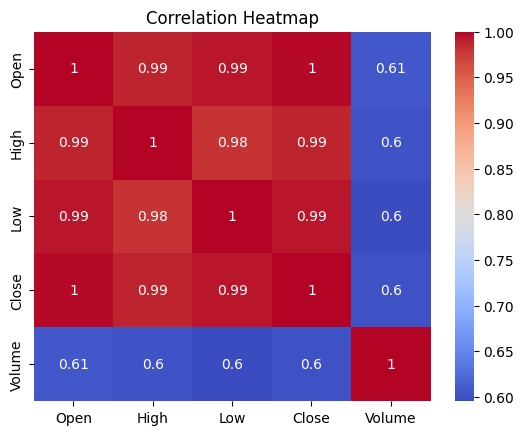

In [14]:
import seaborn as sns

# create a correlation matrix.
correlation_matrix = df.corr()

# add a title to the heatmap.
plt.title('Correlation Heatmap')

# plot the matrix as a heatmap to better visualize the correlation.
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

Outliers

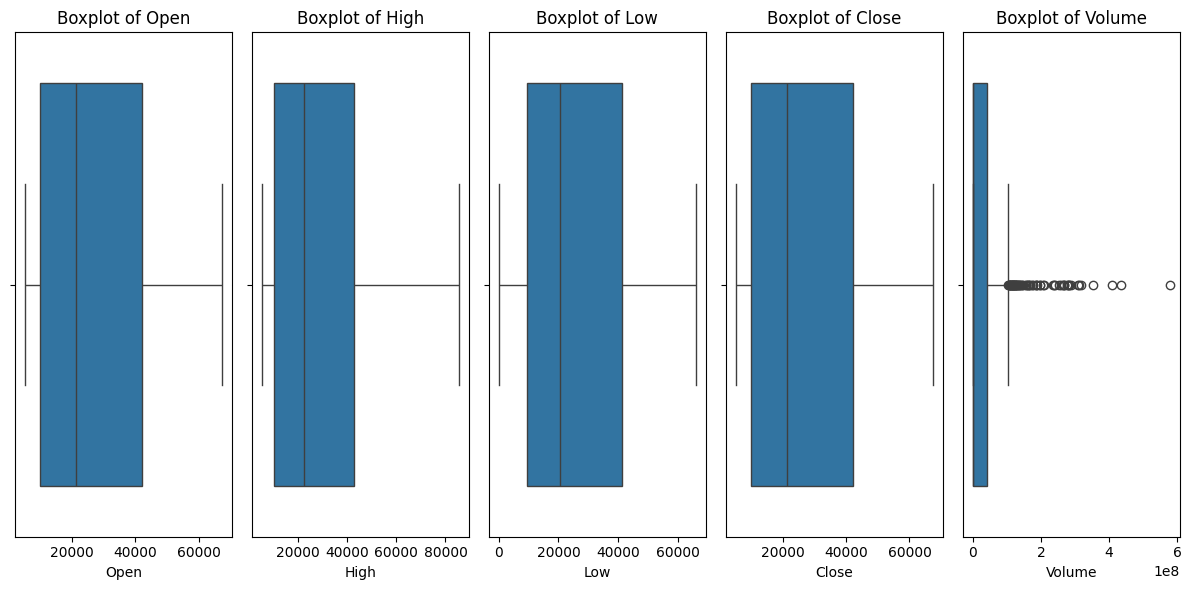

In [15]:
# Get numerical columns in the dataset
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Set up the plot size
plt.figure(figsize=(12, 6))

# Create boxplots for each numerical column
for i, column in enumerate(numerical_columns):
    plt.subplot(1, len(numerical_columns), i + 1)
    sns.boxplot(data=df, x=column)
    plt.title(f'Boxplot of {column}')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

Winsorization of the 'Volume' Column (95th Percentile) to Reduce Noise from Outliers by replacing those extreme values with a value closer to the center of the distribution, such as the 95th percentile value.

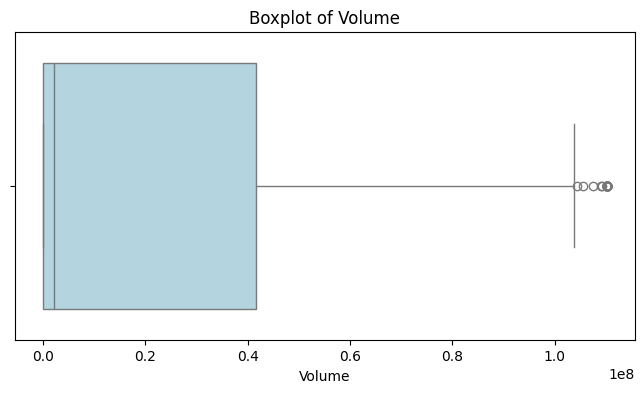

In [16]:
# Calculate the 95th percentile (capping the top 5% of values)
percentile_95 = np.percentile(df['Volume'], 95)

# Cap values greater than the 95th percentile to the value at the 95th percentile
df['Volume'] = np.where(df['Volume'] > percentile_95, percentile_95, df['Volume'])

# Plotting the boxplot to visualize the distribution of 'Volume'
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['Volume'], color='lightblue')
plt.title('Boxplot of Volume')
plt.xlabel('Volume')
plt.show()

Descriptive Statistics

In [17]:
# check the size of tha DataFrame (rows and columns).
df.shape

(1163, 5)

In [18]:
# compute and interpret the mean, median, quartiles and standard deviation of the dataset.
df.describe().round(2)

,Open,High,Low,Close,Volume
count,1163.00,1163.00,1163.00,1163.00,1.163000e+03
mean,26673.77,27712.53,25607.25,26688.38,2.464392e+07
std,17975.97,18440.46,17507.92,17972.23,3.300992e+07
min,4943.83,5338.51,0.08,4936.76,0.000000e+00
25%,9715.40,10127.45,9372.55,9719.31,7.768000e+03
50%,21233.46,22676.55,20536.45,21303.99,2.094426e+06
75%,42223.32,43026.52,41119.30,42226.38,4.166013e+07
max,67470.44,85563.98,66072.34,67502.42,1.101471e+08


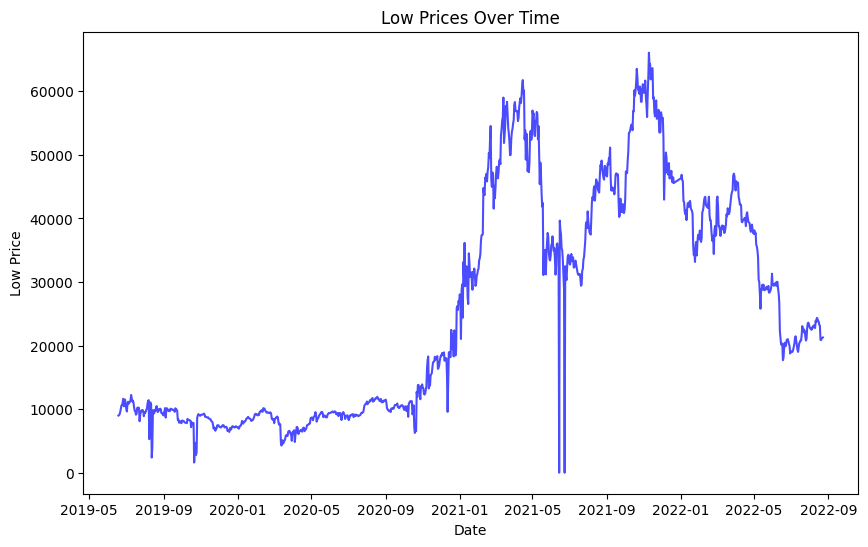

Dates with extreme bottom outliers:
                    Low
2019-08-12  2389.728516
2019-10-21  1602.691650
2019-10-24  2774.954102
2019-10-25  3197.560059
2021-06-14     0.149108
2021-06-23     0.076853


In [19]:
# Plot Low prices over time using a line plot
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Low'], color='blue', alpha=0.7)

# Add titles and labels
plt.title('Low Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Low Price')

# Show the plot
plt.show()

# Find the bottom 0.5% of values (could be considered as outliers)
bottom_outliers = df[df['Low'] < df['Low'].quantile(0.005)]

# Print the dates and corresponding Low values for outliers at the bottom
print("Dates with extreme bottom outliers:")
print(bottom_outliers[['Low']])

Extreme Outliers in 'Low'





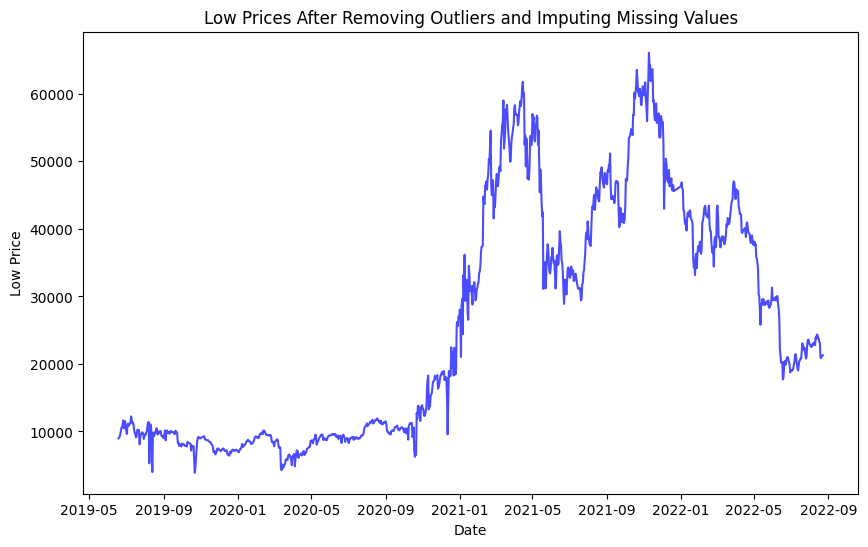

count     1157.000000
mean     25731.433875
std      17467.629997
min       3896.926025
25%       9394.977539
50%      20792.781250
75%      41213.390625
max      66072.343750
Name: Low, dtype: float64


In [20]:
# Identify outliers in the bottom 0.5% of the 'Low' column
bottom_outliers = df[df['Low'] < df['Low'].quantile(0.005)]

# Remove the extreme bottom outliers
df = df.drop(bottom_outliers.index)

# Impute data for the removed outliers using the range of June 2021
# Filter the data for June 2021
june_2021_data = df['Low'].loc['2021-06-01':'2021-06-30']

# Calculate the mean (or median) of the June 2021 data to use for imputation
june_2021_mean = june_2021_data.mean()

# Impute the missing values in the 'Low' column with June 2021's mean value
df['Low'].fillna(june_2021_mean, inplace=True)

# Plot the result
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Low'], color='blue', alpha=0.7)

# Add titles and labels
plt.title('Low Prices After Removing Outliers and Imputing Missing Values')
plt.xlabel('Date')
plt.ylabel('Low Price')

# Show the plot
plt.show()

# Verify the result by checking the description of the 'Low' column
print(df['Low'].describe())

Normal Distribution: Shapiro-Wilk test

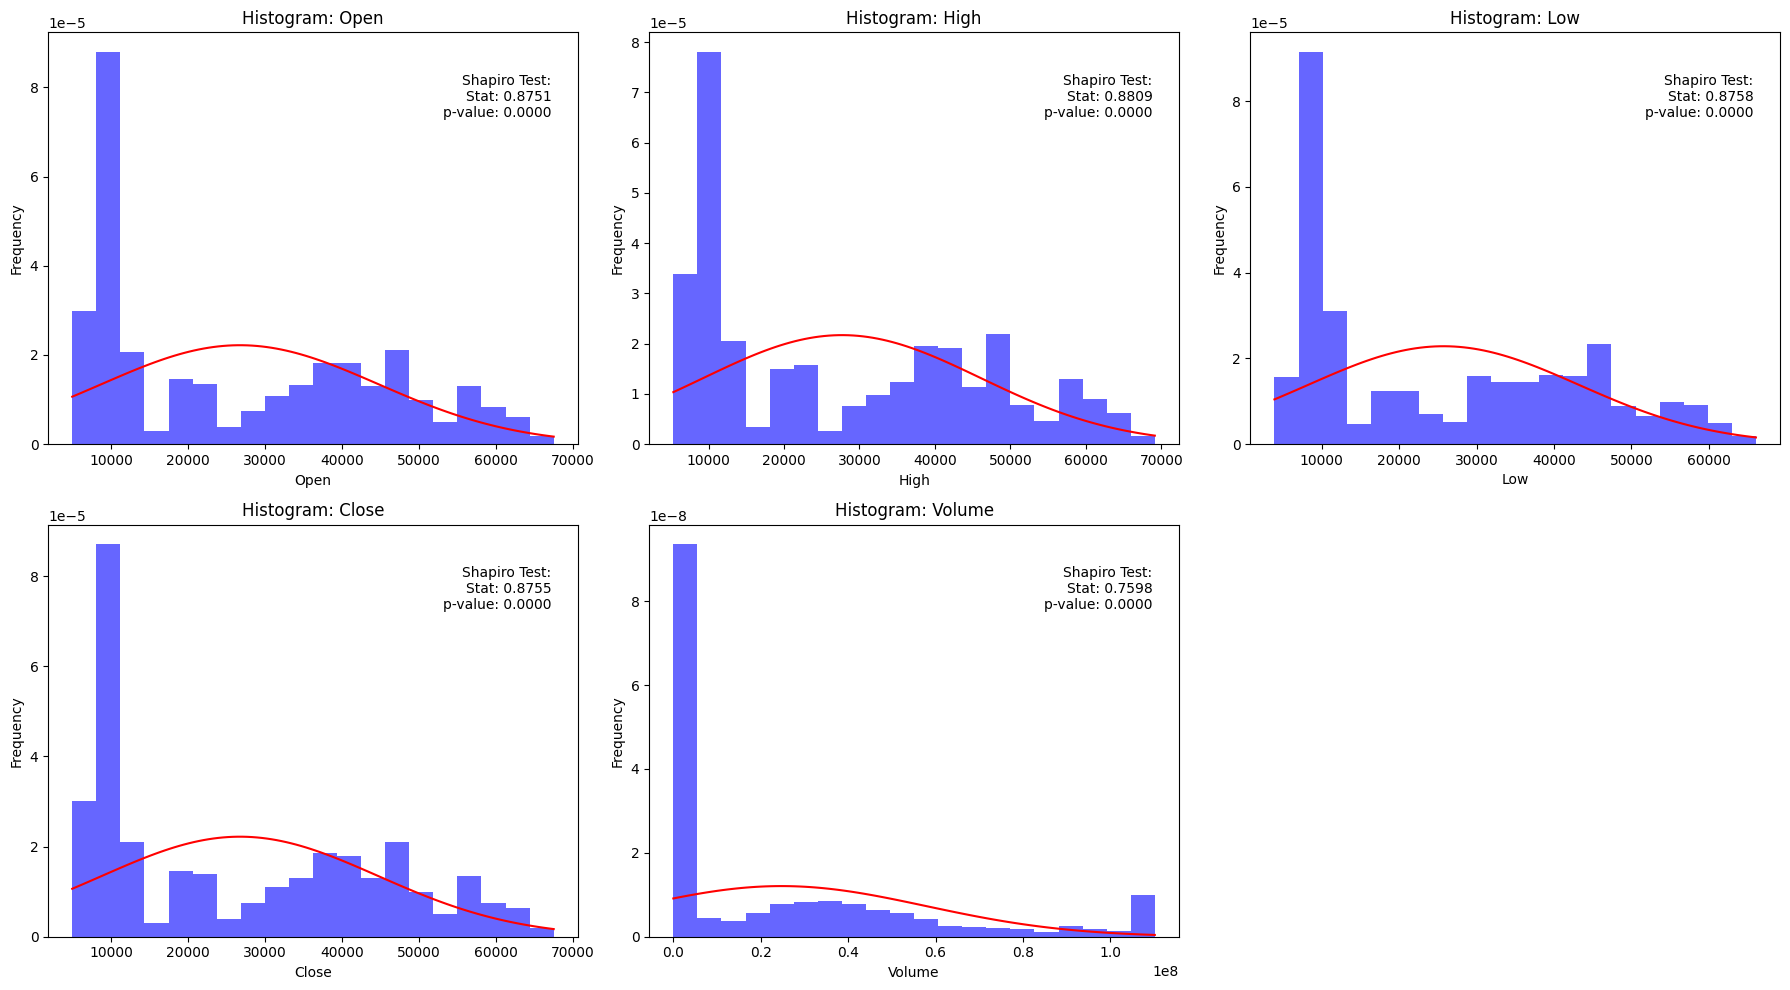

In [21]:
from scipy.stats import norm, shapiro

# Define function to calculate and plot normal distribution curve by Shapiro-Wilk test.
# Add the kernel density estimate (KDE) curve with red color.
def plot_norm_curve(data, ax):
    mean, std = norm.fit(data)
    x = np.linspace(np.min(data), np.max(data), 100)
    y = norm.pdf(x, mean, std)
    ax.plot(x, y, color='red')

# Get the numerical columns.
numerical_columns = df.select_dtypes(include=np.number).columns

# Calculate the number of rows and columns for subplots.
num_cols = 3  # number of columns for subplots.
num_rows = (len(numerical_columns) + num_cols - 1) // num_cols  # number of rows for subplots.

# Create subplots with the desired number of rows and columns.
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 5*num_rows))

# Flatten the axs array if it has multiple rows, so we can iterate over it easily.
if num_rows > 1:
    axs = axs.flatten()

# Plot histograms and normal distribution curves for each variable.
for i, col in enumerate(numerical_columns):
    ax = axs[i]  # Select the appropriate axis for the subplot.
    ax.hist(df[col], bins=20, density=True, alpha=0.6, color='blue')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.set_title('Histogram: ' + col)  # Adding the title
    plot_norm_curve(df[col], ax)

    # Perform Shapiro-Wilk test for normality.
    stat, p_value = shapiro(df[col])
    ax.text(0.95, 0.9, f"Shapiro Test:\nStat: {stat:.4f}\np-value: {p_value:.4f}",
            transform=ax.transAxes, ha='right', va='top')

# Remove any empty subplots.
if len(numerical_columns) < num_rows * num_cols:
    for i in range(len(numerical_columns), num_rows * num_cols):
        axs[i].remove()

# Adjust spacing and layout.
plt.tight_layout()

# Show plot.
plt.show()

Applying Log Transformation to better distribute the data

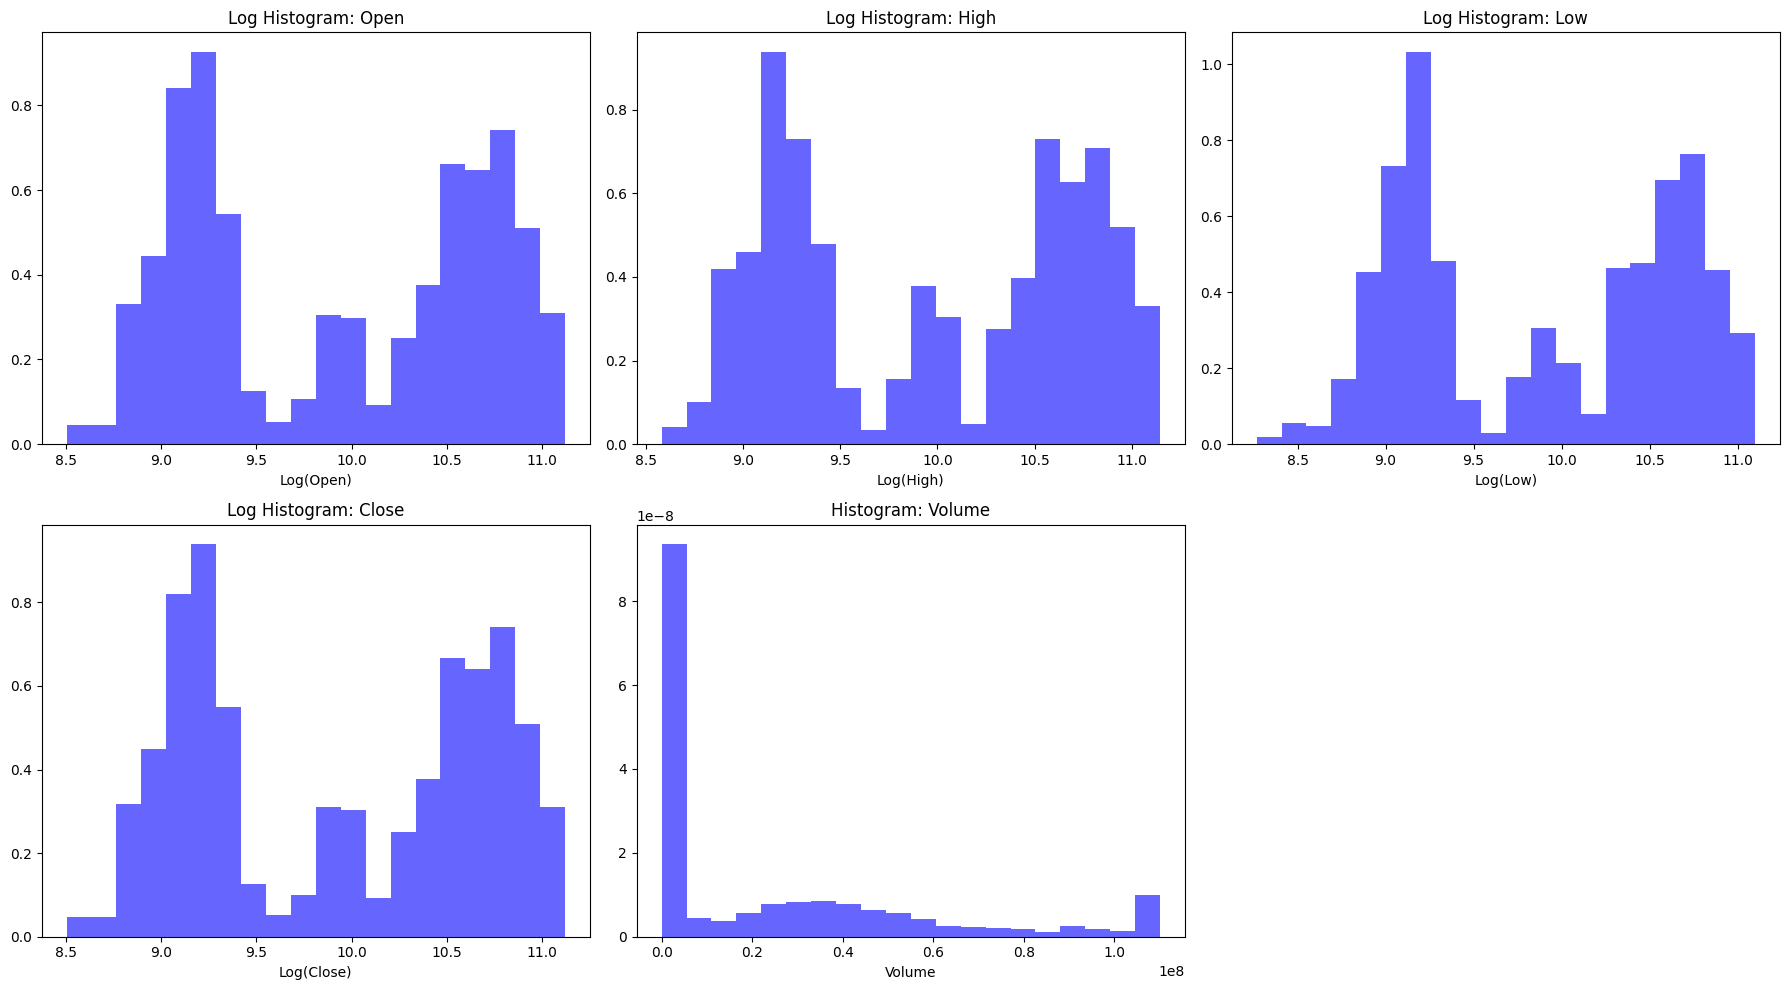

In [22]:
# Get numerical columns in the DataFrame
numerical_columns = df.select_dtypes(include=np.number).columns

# Set up the number of rows and columns for subplots
num_cols = 3  # number of columns for subplots
num_rows = (len(numerical_columns) + num_cols - 1) // num_cols  # number of rows for subplots

# Create subplots with the desired number of rows and columns
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 5*num_rows))

# Flatten the axs array to make it easier to iterate
if num_rows > 1:
    axs = axs.flatten()

# Loop through the numerical columns
for i, col in enumerate(numerical_columns):
    ax = axs[i]  # Select the appropriate axis for the subplot

    # Check if all values in the column are positive (greater than 0)
    if np.all(df[col] > 0):  # Only apply log if all values are > 0
        log_data = np.log(df[col])  # Apply log transformation

        # Plot histogram of the log-transformed data
        ax.hist(log_data, bins=20, density=True, alpha=0.6, color='blue')
        ax.set_xlabel(f"Log({col})")  # Label for log-transformed data
        ax.set_title(f"Log Histogram: {col}")  # Title for the subplot

    else:
        # If the data has non-positive values, plot the original data (without log transformation)
        ax.hist(df[col], bins=20, density=True, alpha=0.6, color='blue')
        ax.set_xlabel(col)
        ax.set_title(f"Histogram: {col}")

# Remove any empty subplots if there are more subplots than numerical columns
if len(numerical_columns) < num_rows * num_cols:
    for i in range(len(numerical_columns), num_rows * num_cols):
        axs[i].remove()

# Adjust spacing and layout
plt.tight_layout()

# Show plot
plt.show()


In [23]:
df.describe().round(2)

,Open,High,Low,Close,Volume
count,1157.00,1157.00,1157.00,1157.00,1.157000e+03
mean,26720.06,27685.79,25731.43,26730.96,2.471611e+07
std,17986.92,18386.49,17467.63,17983.87,3.305417e+07
min,4943.83,5338.51,3896.93,4936.76,0.000000e+00
25%,9718.59,10125.60,9394.98,9725.85,7.606000e+03
50%,21245.37,22676.55,20792.78,21314.74,2.144073e+06
75%,42262.49,43037.52,41213.39,42263.78,4.172562e+07
max,67470.44,69123.69,66072.34,67502.42,1.101471e+08


 Data Preprocessing

Feature Engineering

In [24]:
# Create column by calculating the Price Spread (High - Low) and Price Change (Close - Open)
df['Price_Change'] = df['Close'] - df['Open']
df['Price_Spread'] = df['High'] - df['Low']

# Define the time window (5 days)
time_windows = {
    'Close': 5
}

# Shift the 'Close' column by the number of days for each time window and create new target columns
for target_name, days in time_windows.items():
    df['Closing_Price'] = df[target_name].shift(days)

# Drop rows with NaN values in any of the target columns (due to shifting)
df = df.dropna()

# Define feature columns
features = ['Open', 'High', 'Low', 'Volume', 'Price_Change', 'Price_Spread']

# Define X (features) and y (target)
X = df[features]
y = df['Closing_Price']  # Target variable: shifted close

# DataFrame now has a target column for the respective time window
print(df.head())

                    Open          High           Low         Close    Volume  \
2019-06-23  10718.117188  11293.773438  10561.124023  11246.518555   52072.0   
2019-06-24  11246.518555  11251.156250  10659.144531  11010.517578  106205.0   
2019-06-25  10999.733398  11676.888672  10999.733398  11666.965820   95820.0   
2019-06-26  11666.965820  13739.329102  11631.251953  12827.663086   67574.0   
2019-06-27  12827.663086  13022.981445  10452.151367  11136.211914  117404.0   

            Price_Change  Price_Spread  Closing_Price  
2019-06-23    528.401367    732.649414    9062.045898  
2019-06-24   -236.000977    592.011719    9271.459961  
2019-06-25    667.232422    677.155273    9519.200195  
2019-06-26   1160.697266   2108.077148   10127.998047  
2019-06-27  -1691.451172   2570.830078   10719.981445  


Normalization - Scaling the Features

In [25]:
from sklearn.preprocessing import MinMaxScaler

# Select numerical features
features = ['Open', 'High', 'Low', 'Volume', 'Price_Change', 'Price_Spread']

# Scaling the features
scaler = MinMaxScaler()

# Fit and transform the selected features
df[features] = scaler.fit_transform(df[features])

print(df.head())

                Open      High       Low         Close    Volume  \
2019-06-23  0.092349  0.093364  0.107184  11246.518555  0.000473   
2019-06-24  0.100800  0.092696  0.108760  11010.517578  0.000964   
2019-06-25  0.096853  0.099371  0.114238  11666.965820  0.000870   
2019-06-26  0.107524  0.131705  0.124395  12827.663086  0.000613   
2019-06-27  0.126088  0.120474  0.105431  11136.211914  0.001066   

            Price_Change  Price_Spread  Closing_Price  
2019-06-23      0.519348      0.021165    9062.045898  
2019-06-24      0.464196      0.016677    9271.459961  
2019-06-25      0.529364      0.019394    9519.200195  
2019-06-26      0.564968      0.065057   10127.998047  
2019-06-27      0.359185      0.079824   10719.981445  


Phase 2: Feature Selection Techniques

In [26]:
from sklearn.feature_selection import mutual_info_regression, RFE
from sklearn.linear_model import LinearRegression, Lasso

# Filter Method: Information Gain (Mutual Information)
info_gain = mutual_info_regression(X, y)
info_gain_series = pd.Series(info_gain, index=X.columns).sort_values(ascending=False)

# Select the top k features based on Information Gain
k = 5  # Change this to select more or fewer features
top_k_features_info_gain = info_gain_series.head(k).index
print(f"Top {k} features selected using Information Gain: {top_k_features_info_gain}")


# Wrapper Method: Recursive Feature Elimination (RFE)
# Initialize the model
model = LinearRegression()

# Initialize RFE with the model and the number of features to select
rfe = RFE(estimator=model, n_features_to_select=5)
rfe.fit(X, y)
selected_features_rfe = X.columns[rfe.support_]
print(f"Top {k} features selected using RFE: {selected_features_rfe}")


# Embedded Method: Lasso Regression
# Initialize Lasso regression with a smaller alpha value
lasso = Lasso(alpha=0.001)  # Adjust alpha to control feature selection strength
lasso.fit(X, y)

# Get the absolute value of the coefficients and sort them
coef_abs = np.abs(lasso.coef_)

# Get the indices of the top_k features with the highest absolute coefficients
top_k_lasso_indices = np.argsort(coef_abs)[-k:]  # Get indices of the top_k features

# Select the top_k features based on the highest absolute coefficient values
top_k_features_lasso = X.columns[top_k_lasso_indices]
print(f"Top {k} features selected using Lasso: {top_k_features_lasso}")

Top 5 features selected using Information Gain: Index(['Open', 'Low', 'High', 'Volume', 'Price_Spread'], dtype='object')
Top 5 features selected using RFE: Index(['Open', 'High', 'Low', 'Price_Change', 'Price_Spread'], dtype='object')
Top 5 features selected using Lasso: Index(['Low', 'Price_Spread', 'High', 'Price_Change', 'Open'], dtype='object')


Comparison of Different Feature Selection Methods

In [27]:
# Create a DataFrame to compare the selected features from all methods
comparison_df = pd.DataFrame({
    'Information Gain': pd.Series(top_k_features_info_gain),
    'RFE': pd.Series(selected_features_rfe),
    'Lasso': pd.Series(top_k_features_lasso)
})


# Find common features selected by all methods and sort them for consistent ordering
common_features = sorted(list(set(top_k_features_info_gain) & set(selected_features_rfe) & set(top_k_features_lasso)))
print(f"\nCommon features selected by all methods: {common_features}")


Common features selected by all methods: ['High', 'Low', 'Open', 'Price_Spread']


Phase 3: Model Training and Evaluation

Split the data into training and testing sets


In [28]:
from sklearn.model_selection import train_test_split

# Define feature columns and target variable
features = ['High', 'Low', 'Open', 'Price_Spread']  # Independent variables (features)
X = df[features]  # Features

# Use 'Closing_Price' as the target variable
y = df['Closing_Price']   # Target variable (shifted closing price)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
# Print the size of the training and testing sets
print("Training set size (X_train, y_train):", X_train.shape, y_train.shape)
print("Testing set size (X_test, y_test):", X_test.shape, y_test.shape)

Training set size (X_train, y_train): (806, 4) (806,)
Testing set size (X_test, y_test): (346, 4) (346,)


Random Forest Model

In [30]:
from sklearn.ensemble import RandomForestRegressor

# Create the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit Random Forest model on the training data
rf_model.fit(X_train, y_train)

# Test the model using score method (which returns R-squared)
rf_score = rf_model.score(X_test, y_test)  # Use test data for scoring
print('Random Forest Model score:', rf_score)

# Make predictions on the test set or a specific row for comparison
rf_predictions = rf_model.predict(X_test)  # Predictions on test data

# Make predictions for the last row (for comparison)
new_data = df[features].tail(1)  # Selecting the last row for prediction
rf_last_prediction = rf_model.predict(new_data)  # Random Forest prediction for the last row

# Save the model and predictions
rf_result = {'model': rf_model, 'predictions': rf_predictions, 'y_test': y_test}

# Display the last prediction and actual value
print('Random Forest predicts the last row or day to be:', rf_last_prediction[0])
print('Actual value is:', df['Close'].tail(1).values[0])

Random Forest Model score: 0.9746860354257394
Random Forest predicts the last row or day to be: 22856.990546875
Actual value is: 21303.986328125


Linear Regression Model

In [31]:
from sklearn.linear_model import LinearRegression

# Create the model
lr_model = LinearRegression()

# Fit linear regression model on the training data
lr_model.fit(X_train, y_train)

# Test the model using score method (which returns R-squared)
lr_score = lr_model.score(X_test, y_test)  # Use test data for scoring
print('Linear Regression Model score:', lr_score)

# Make predictions on the test set or a specific row for comparison
lr_predictions = lr_model.predict(X_test)  # Predictions on test data

# Make predictions for the last row (for comparison)
new_data = df[features].tail(1)  # Selecting the last row for prediction
lr_last_prediction = lr_model.predict(new_data)  # Linear Regression prediction for the last row

# Save the model and predictions
lr_result = {'model': lr_model, 'predictions': lr_predictions, 'y_test': y_test}

# Display the last prediction and actual value
print('Linear Regression predicts the last row or day to be:', lr_last_prediction[0])
print('Actual value is:', df['Close'].tail(1).values[0])


Linear Regression Model score: 0.9802382684989048
Linear Regression predicts the last row or day to be: 21335.847648181727
Actual value is: 21303.986328125


K-Nearest Neighbors (KNN) Model

In [32]:
from sklearn.neighbors import KNeighborsRegressor

# Create the model
knn_model = KNeighborsRegressor(n_neighbors=5)

# Fit KNN model on the training data
knn_model.fit(X_train, y_train)

# Test the model using score method (which returns R-squared)
knn_score = knn_model.score(X_test, y_test)  # Use test data for scoring
print('KNN Model score:', knn_score)

# Make predictions on the test set or a specific row for comparison
knn_predictions = knn_model.predict(X_test)  # Predictions on test data

# Make predictions for the last row (for comparison)
new_data = df[features].tail(1)  # Selecting the last row for prediction
knn_last_prediction = knn_model.predict(new_data)  # KNN prediction for the last row

# Save the model and predictions
knn_result = {'model': knn_model, 'predictions': knn_predictions, 'y_test': y_test}

# Display the last prediction and actual value
print('KNN predicts the last row or day to be:', knn_last_prediction[0])
print('Actual value is:', df['Close'].tail(1).values[0])

KNN Model score: 0.9731860803393549
KNN predicts the last row or day to be: 22414.38046875
Actual value is: 21303.986328125


Evaluate Models: Root Mean Squared Error (RMSE) Calculation

In [33]:
from sklearn.metrics import mean_squared_error

# Function to calculate RMSE for each model
def evaluate_model(model_result):
    predictions = model_result['predictions']
    y_true = model_result['y_test']

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_true, predictions))
    return rmse

# Evaluate each model
knn_rmse = evaluate_model(knn_result)
rf_rmse = evaluate_model(rf_result)
lr_rmse = evaluate_model(lr_result)

# Print RMSE for each model
print(f'KNN Model RMSE: {knn_rmse}')
print(f'Random Forest Model RMSE: {rf_rmse}')
print(f'Linear Regression Model RMSE: {lr_rmse}')

KNN Model RMSE: 2940.640403087096
Random Forest Model RMSE: 2857.2079643643956
Linear Regression Model RMSE: 2524.4935486952713


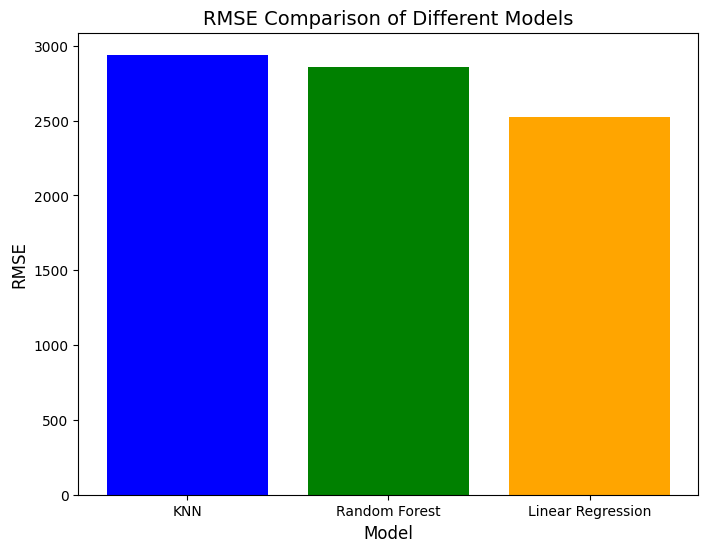

In [34]:
# Define the RMSE values
rmse_values = [knn_rmse, rf_rmse, lr_rmse]
model_names = ['KNN', 'Random Forest', 'Linear Regression']

# Create the plot
plt.figure(figsize=(8, 6))
plt.bar(model_names, rmse_values, color=['blue', 'green', 'orange'])

# Add title and labels
plt.title('RMSE Comparison of Different Models', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('RMSE', fontsize=12)

# Show the plot
plt.show()

Reference:

- https://github.com/usmanakhtar/Cryptocurrency-Dataset/